In [15]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
import numpy as np
from pathlib import Path

In [2]:
split = 3

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")


In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]


In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [8]:
adata_pred_ood.var_names = adata_ood.var_names

In [9]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [10]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [27]:
ood_conditions=adata_ood.obs["condition"].unique()

def get_mode(x):
    if "pred" in x["condition"]:
        return "pred"
    if x["condition"] in ood_conditions:
        return "true"
    return "seen"

In [177]:
from typing import Any, Literal
from sklearn.decomposition import KernelPCA
from sklearn.cross_decomposition import CCA
from cca_zoo.nonparametric import KCCA
from cca_zoo.datasets import JointData
from cca_zoo.linear import GCCA, MCCA, SPLS, TCCA
import pandas as pd
from cca_zoo.nonparametric import KCCA, KGCCA, KTCCA

def predict_with_kernel_cca(embeddings_seen: pd.DataFrame, target_variable: pd.Series, embeddings_unseen: pd.DataFrame, kernel: Literal["linear", "poly", "rbf", "sigmoid", "cosine"] = "poly", kernel_kwargs: Any = {}, return_all_data: bool = False) -> pd.Series:
    """Predict target variable for unseen data using canonical correlation analysis (CCA).

    Parameters
    ----------
    embeddings_seen
        Embeddings of the seen data. Index corresponding to condition names, values to embeddings.
    target_variable
        Target variable of the seen data. Index corresponding to condition names, values to target variable.
    embeddings_unseen
        Embeddings of the unseen data. Index corresponding to condition names, values to embeddings which to 
        predict the target variable.
    kernel
        Kernel for Kernel CCA.
    kernel_kwargs
        Keyword arguments for Kernel
    return_all_data
        Also returns the latent values for the seen embeddings
    

    Returns
    -------
    Predicted target variable for the unseen data.
    """
    X = embeddings_seen.values
    X_mean = X.mean(axis=0)
    X -= X_mean
    y = target_variable.loc[embeddings_seen.index].values.reshape(-1, 1).astype('float64')
    y_mean = y.mean(axis=0)
    y -= y_mean

    
    kcca = KCCA(latent_dimensions=1, kernel=kernel, **kernel_kwargs)
    kcca.fit((X, y))
    _, y_c = kcca.transform((X, y))
    correct_orientation = np.corrcoef((y_c.squeeze()), y.squeeze())[0,1] > 0.0
    
    
    X_new = embeddings_unseen.values
    X -= X_mean
    y_pred = kcca.transform((X_new, None))[0]

    projections_unseen = pd.Series(index=embeddings_unseen.index, data=y_pred.squeeze() * (1.0 if correct_orientation else -1.0))
    
    if not return_all_data:
        return projections_unseen

    projections_seen = pd.Series(index=embeddings_seen.index, data=y_c.squeeze() * (1.0 if correct_orientation else -1.0)).to_frame(name="latent_dim")
    projections_seen["mode"] = "seen"
    projections_unseen = projections_unseen.to_frame(name="latent_dim")
    projections_unseen["mode"] = "unseen"
    return pd.concat((projections_seen, projections_unseen))

In [208]:
# "linear", "poly", "rbf", "sigmoid", "cosine"
target_variable = "COL26A1"
y = df_seen[target_variable]
kernel= "poly"
kernel_kwargs = {"degree": [50, 1]}
latent_dim_old = out["latent_dim"]
out = predict_with_kernel_cca(df_emb.loc[df_seen.index], y[df_seen.index], df_emb.loc[df_unseen.index], kernel=kernel, kernel_kwargs=kernel_kwargs, return_all_data=True)

In [209]:
df_data_red = df_data.loc[out.index]

In [210]:
df_merged = pd.merge(df_data_red, out, left_index=True, right_index=True)

<Axes: xlabel='COL26A1', ylabel='latent_dim'>

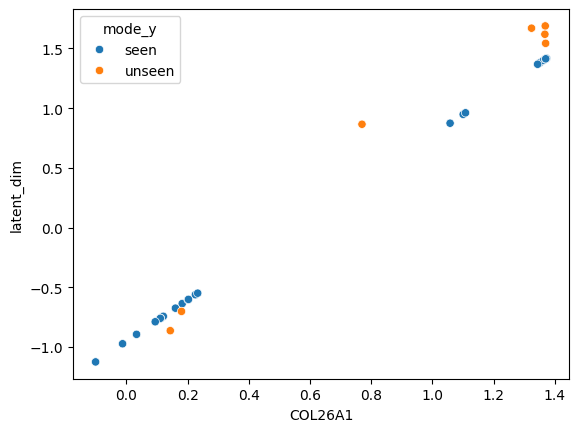

In [211]:
sns.scatterplot(df_merged, x=target_variable, y="latent_dim", hue="mode_y")

In [187]:
out["latent_dim"] - latent_dim_old

control+Panobinostat         1.005862e-13
Cediranib+PCI-34051          1.016964e-13
Givinostat+SRT1720           1.015854e-13
Panobinostat+SRT3025         1.008083e-13
Panobinostat+PCI-34051       1.008083e-13
Dacinostat+PCI-34051         1.008083e-13
Givinostat+Cediranib         1.015854e-13
control+Givinostat           1.013634e-13
Dacinostat+Danusertib        1.008083e-13
Panobinostat+Dasatinib       1.010303e-13
Givinostat+Tanespimycin      1.015854e-13
Givinostat+Carmofur          1.013634e-13
Panobinostat+SRT2104         1.010303e-13
Alvespimycin+Pirarubicin     1.013634e-13
Givinostat+SRT2104           1.013634e-13
Givinostat+Sorafenib         1.013634e-13
Panobinostat+Alvespimycin    1.008083e-13
Givinostat+Dasatinib         1.014744e-13
Dacinostat+Dasatinib         1.011413e-13
control+SRT2104              1.016964e-13
Givinostat+Curcumin          1.014744e-13
Givinostat+Crizotinib        1.013634e-13
SRT3025+Cediranib            1.014744e-13
control+Dasatinib            1.015

In [92]:
df_data

,AKR1B10,COL26A1,condition,mode
control+Panobinostat,-1.150555,1.350277,control+Panobinostat,seen
Cediranib+PCI-34051,-0.011246,-0.100875,Cediranib+PCI-34051,seen
Givinostat+SRT1720,-0.009713,0.119718,Givinostat+SRT1720,seen
Panobinostat+SRT3025,-1.240494,1.3621,Panobinostat+SRT3025,seen
Panobinostat+PCI-34051,-1.231206,1.372558,Panobinostat+PCI-34051,seen
Dacinostat+PCI-34051,-0.665282,1.057506,Dacinostat+PCI-34051,seen
Givinostat+Cediranib,-0.014794,0.114827,Givinostat+Cediranib,seen
control+Givinostat,-0.01684,0.120417,control+Givinostat,seen
Dacinostat+Danusertib,-0.658346,1.100291,Dacinostat+Danusertib,seen
Panobinostat+Dasatinib,-1.128595,1.368903,Panobinostat+Dasatinib,seen


In [91]:
out

,0,mode
control+Panobinostat,-1.526848,seen
Cediranib+PCI-34051,0.717437,seen
Givinostat+SRT1720,0.720457,seen
Panobinostat+SRT3025,-1.704015,seen
Panobinostat+PCI-34051,-1.685719,seen
Dacinostat+PCI-34051,-0.570927,seen
Givinostat+Cediranib,0.710447,seen
control+Givinostat,0.706417,seen
Dacinostat+Danusertib,-0.557263,seen
Panobinostat+Dasatinib,-1.483588,seen


In [36]:
df_emb = pd.read_csv("cond_embedding_split_3.csv")
df_emb = df_emb.set_index("condition")
df_emb = df_emb[[str(i) for i in np.arange(1024)]]

In [37]:
df_emb

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
condition,,,,,,,,,,,,,,,,,,,,,
control+Panobinostat,-0.065851,0.093432,0.070940,0.015050,-0.029860,0.065578,-0.133805,0.124684,0.162144,0.057902,...,0.064464,0.058650,0.062395,0.135613,-0.015411,0.161919,0.095210,-0.088973,0.176529,0.078379
Dacinostat+PCI-34051,-0.051831,0.075074,0.196367,-0.105981,0.065105,-0.032872,-0.014661,0.074427,0.081477,0.014220,...,-0.078002,0.088564,0.115534,0.005865,0.012597,0.084751,0.138078,0.077968,0.081665,0.043688
Panobinostat+PCI-34051,-0.085379,0.092720,0.045955,-0.010191,-0.079097,0.129343,-0.188612,0.128739,0.148452,0.125378,...,0.072976,0.045673,-0.035753,0.182319,-0.072187,0.138169,0.046464,-0.111438,0.175520,0.168398
Givinostat+Cediranib,0.013281,0.003620,0.001265,0.020887,0.049096,0.012018,0.024171,-0.039773,-0.045767,-0.045202,...,-0.113553,0.088467,-0.053722,-0.034451,-0.071725,-0.040084,0.035483,0.097984,-0.016091,0.052631
Dacinostat+Danusertib,-0.062804,0.083230,0.177259,-0.054953,0.047358,-0.078884,-0.033429,0.087245,0.087884,-0.036226,...,-0.028616,0.078485,0.150131,0.002616,0.030590,0.127646,0.135675,0.079049,0.120112,-0.037608
Panobinostat+Dasatinib,-0.076005,-0.133364,0.077688,-0.109090,-0.080319,0.074252,-0.170568,0.126836,0.051739,0.030809,...,0.065105,-0.137229,0.041887,0.189498,-0.160864,0.191201,0.125007,-0.122196,0.064068,0.126797
Givinostat+Tanespimycin,-0.149346,0.101104,-0.000438,0.158802,-0.146610,0.036721,0.026373,0.036498,0.037892,-0.079724,...,0.103529,-0.030090,0.038898,-0.033592,0.085534,-0.025438,-0.055439,-0.061355,0.065976,0.019057
Alvespimycin+Pirarubicin,-0.139815,-0.157940,-0.167370,0.001219,-0.166920,0.205898,0.034757,0.074908,-0.081667,0.032478,...,0.166794,-0.068945,-0.074562,0.010830,0.128901,-0.040014,-0.157852,-0.212182,0.130663,-0.018909
Givinostat+Sorafenib,0.039656,-0.139928,0.026723,0.110226,0.209899,0.045083,0.061326,-0.009633,-0.044854,-0.169293,...,-0.041527,-0.139436,0.228454,-0.039581,-0.042217,0.051813,0.200298,-0.025112,-0.089391,-0.030446


In [62]:
genes_selected = ["AKR1B10", "COL26A1"]
df_data = pd.DataFrame(columns=genes_selected)
control = adata_full[adata_full.obs["condition"]=="control", adata_full.var_names.isin(genes_selected)]
for cond in adata_full.obs["condition"].unique():
    if cond=="control":
        continue
    treated = adata_full[adata_full.obs["condition"]==cond, adata_full.var_names.isin(genes_selected)]
    mean_control = np.mean(np.asarray(control.X.toarray()), axis=0)  
    mean_treated = np.mean(np.asarray(treated.X.toarray()), axis=0)  
    log_fold_change = np.log2(mean_control + 1) - np.log2(mean_treated + 1)
    
    
    df_data.loc[cond,:] = log_fold_change
    

In [63]:
df_data

,AKR1B10,COL26A1
control+Panobinostat,-1.150555,1.350277
Cediranib+PCI-34051,-0.011246,-0.100875
Givinostat+SRT1720,-0.009713,0.119718
Panobinostat+SRT3025,-1.240494,1.3621
Panobinostat+PCI-34051,-1.231206,1.372558
Dacinostat+PCI-34051,-0.665282,1.057506
Givinostat+Cediranib,-0.014794,0.114827
control+Givinostat,-0.01684,0.120417
Dacinostat+Danusertib,-0.658346,1.100291
Panobinostat+Dasatinib,-1.128595,1.368903


In [64]:
df_data["condition"] = df_data.index
df_data["mode"] = df_data.apply(get_mode, axis=1)

In [88]:
target_variables = ["COL26A1", "AKR1B10"]
corr_result = {}


for kernel in ['sigmoid',  'poly', 'laplacian', 'cosine', 'rbf', 'linear', 'polynomial']:
    
    corrs = []
    for target_variable in target_variables: 
        df_seen = df_data[df_data["mode"]=="seen"]
        df_unseen = df_data[df_data["mode"]=="true"]
        y = df_seen[target_variable]
        out = predict_with_kernel_cca(df_emb.loc[df_seen.index], y[df_seen.index], df_emb.loc[df_unseen.index], kernel=kernel)
        df_unseen["cca_score"] = out
        df_unseen["score_true_rank"] = df_unseen[target_variable].rank()
        df_unseen["cca_score_rank"] = df_unseen["cca_score"].rank()
        corrs.append(df_unseen[["score_true_rank", "cca_score"]].corr(method="spearman").iloc[0,1])
    corr_result[kernel] = np.array(corrs).mean()
        

0.9915878212421303
0.9857535243012714
0.9883666910486226
0.9830417880376703
0.9941905402746307
0.9963799974345859
0.9936931148965591
0.9936931148965591
0.9576045841085574
0.9567022509489997
0.9998551863157257
0.999817168675674
0.9883666910486226
0.9830417880376703


/tmp/ipykernel_1912087/3002557988.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unseen["cca_score"] = out
/tmp/ipykernel_1912087/3002557988.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unseen["score_true_rank"] = df_unseen[target_variable].rank()
/tmp/ipykernel_1912087/3002557988.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [66]:
corr_result

{'sigmoid': 0.8571428571428572,
 'poly': 0.8571428571428572,
 'laplacian': 0.625,
 'cosine': 0.5357142857142857,
 'rbf': 0.8214285714285714,
 'linear': 0.8571428571428572,
 'polynomial': 0.8571428571428572}

In [51]:
df_unseen

,AKR1B10,COL26A1,condition,mode,cca_score,score_true_rank,cca_score_rank
control+Dacinostat,0.274068,0.574458,control+Dacinostat,true,0.269037,3.0,3.0
Panobinostat+Sorafenib,1.362369,0.038686,Panobinostat+Sorafenib,true,0.725820,6.0,7.0
Panobinostat+SRT1720,1.183243,0.072408,Panobinostat+SRT1720,true,0.706143,4.0,6.0
Panobinostat+Crizotinib,1.540536,0.03956,Panobinostat+Crizotinib,true,0.681985,7.0,5.0
control+Alvespimycin,0.01374,1.369582,control+Alvespimycin,true,0.009486,2.0,2.0
Panobinostat+Curcumin,1.262506,0.040441,Panobinostat+Curcumin,true,0.680925,5.0,4.0
SRT2104+Alvespimycin,0.009653,1.430531,SRT2104+Alvespimycin,true,0.004723,1.0,1.0


In [53]:
combosciplex_color_dict = {
    'Alvespimycin+Pirarubicin': '#fa0e03',
    'Cediranib+PCI-34051': '#0d3290',
    'Dacinostat+Danusertib': '#33ff57',
    'Dacinostat+Dasatinib': '#6300b5',
    'Dacinostat+PCI-34051': '#88e200',
    'Givinostat+Carmofur': '#8e3101',
    'Givinostat+Cediranib': '#1F7530',
    'Givinostat+Crizotinib': '#6ca05c',
    'Givinostat+Curcumin': '#03cd4A',
    'Givinostat+Dasatinib': '#9106eb',
    'Givinostat+SRT1720': '#EB984E',
    'Givinostat+SRT2104': '#260374',
    'Givinostat+Sorafenib': '#ff5733', 
    'Givinostat+Tanespimycin': '#a3e3af',
    'Panobinostat+Alvespimycin': '#46adaf',
    'Panobinostat+Crizotinib': '#8E1382',
    'Panobinostat+Curcumin': '#bdfd0b',
    'Panobinostat+Dasatinib': '#ce606c',
    'Panobinostat+PCI-34051': '#795548',
    'Panobinostat+SRT1720': '#22bb34',
    'Panobinostat+SRT2104': '#8D6E63',
    'Panobinostat+SRT3025': '#9d8303',
    'Panobinostat+Sorafenib': '#d7fdfd',
    'SRT2104+Alvespimycin': '#f502f3',
    'SRT3025+Cediranib': '#f502f3',
    'control+Alvespimycin': '#6ea3fa',
    'control+Dacinostat': '#d6a5fa',
    'control+Dasatinib': '#2d62a3',
    'control+Givinostat': '#5deb2e',
    'control+Panobinostat': '#b1cd3f',
    'control+SRT2104': '#7788cd',
    'control': "#8f97a8"
}


In [56]:
df_unseen

,AKR1B10,COL26A1,condition,mode,cca_score,score_true_rank,cca_score_rank,color
control+Dacinostat,0.274068,0.574458,control+Dacinostat,true,0.269037,3.0,3.0,#d6a5fa
Panobinostat+Sorafenib,1.362369,0.038686,Panobinostat+Sorafenib,true,0.725820,6.0,7.0,#d7fdfd
Panobinostat+SRT1720,1.183243,0.072408,Panobinostat+SRT1720,true,0.706143,4.0,6.0,#22bb34
Panobinostat+Crizotinib,1.540536,0.03956,Panobinostat+Crizotinib,true,0.681985,7.0,5.0,#8E1382
control+Alvespimycin,0.01374,1.369582,control+Alvespimycin,true,0.009486,2.0,2.0,#6ea3fa
Panobinostat+Curcumin,1.262506,0.040441,Panobinostat+Curcumin,true,0.680925,5.0,4.0,#bdfd0b
SRT2104+Alvespimycin,0.009653,1.430531,SRT2104+Alvespimycin,true,0.004723,1.0,1.0,#f502f3


/tmp/ipykernel_1912087/1098123120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unseen['color'] = df_unseen['condition'].map(combosciplex_color_dict)
/tmp/ipykernel_1912087/1098123120.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(df_unseen['score_true_rank'][i] + 0.05, df_unseen['cca_score_rank'][i], df_unseen['condition'][i], fontsize=9)


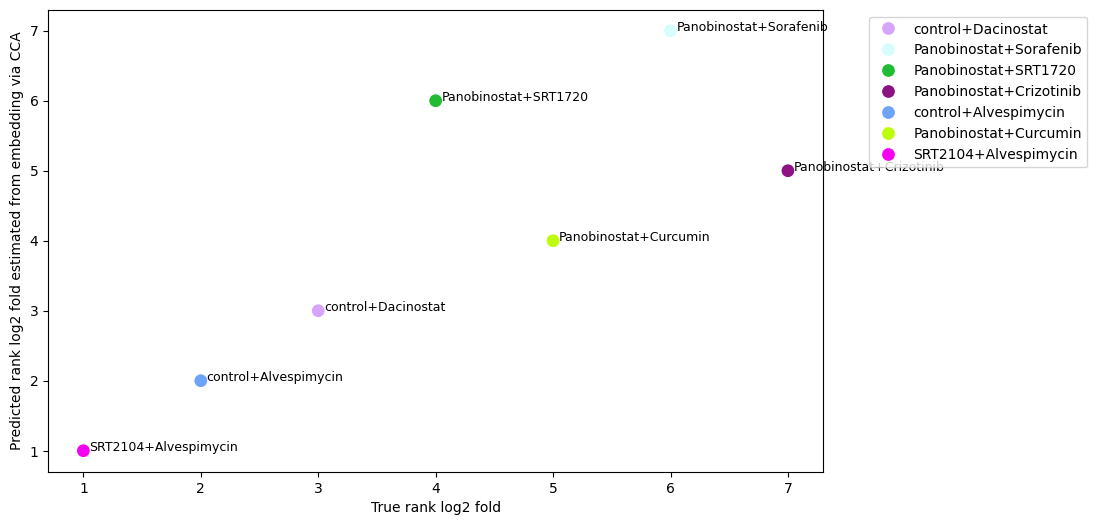

In [59]:
import seaborn as sns
df_unseen['color'] = df_unseen['condition'].map(combosciplex_color_dict)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(df_unseen, x="score_true_rank", y="cca_score_rank", hue="condition", palette=combosciplex_color_dict, s=100)

# Annotate each point
for i in range(df_unseen.shape[0]):
    plt.text(df_unseen['score_true_rank'][i] + 0.05, df_unseen['cca_score_rank'][i], df_unseen['condition'][i], fontsize=9)

# Set labels
plt.xlabel("True rank log2 fold")
plt.ylabel("Predicted rank log2 fold estimated from embedding via CCA")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [67]:
out = predict_with_kernel_cca(df_emb.loc[df_seen.index], y[df_seen.index], df_emb.loc[df_seen.index], kernel=kernel)

In [68]:
out

control+Panobinostat        -0.575008
Cediranib+PCI-34051          0.183064
Givinostat+SRT1720           0.182772
Panobinostat+SRT3025        -0.646285
Panobinostat+PCI-34051      -0.663879
Dacinostat+PCI-34051        -0.322011
Givinostat+Cediranib         0.187433
control+Givinostat           0.191513
Dacinostat+Danusertib       -0.340508
Panobinostat+Dasatinib      -0.662663
Givinostat+Tanespimycin      0.151587
Givinostat+Carmofur          0.184552
Panobinostat+SRT2104        -0.582370
Alvespimycin+Pirarubicin    -0.003621
Givinostat+SRT2104           0.170664
Givinostat+Sorafenib         0.091849
Panobinostat+Alvespimycin   -0.729646
Givinostat+Dasatinib         0.143672
Dacinostat+Dasatinib        -0.336214
control+SRT2104              0.179432
Givinostat+Curcumin          0.164480
Givinostat+Crizotinib        0.180908
SRT3025+Cediranib            0.170312
control+Dasatinib            0.140952
dtype: float64

In [76]:
y

control+Panobinostat        -1.150555
Cediranib+PCI-34051         -0.011246
Givinostat+SRT1720          -0.009713
Panobinostat+SRT3025        -1.240494
Panobinostat+PCI-34051      -1.231206
Dacinostat+PCI-34051        -0.665282
Givinostat+Cediranib        -0.014794
control+Givinostat           -0.01684
Dacinostat+Danusertib       -0.658346
Panobinostat+Dasatinib      -1.128595
Givinostat+Tanespimycin     -0.008633
Givinostat+Carmofur         -0.013876
Panobinostat+SRT2104        -1.182863
Alvespimycin+Pirarubicin     0.000977
Givinostat+SRT2104            -0.0144
Givinostat+Sorafenib        -0.007303
Panobinostat+Alvespimycin   -1.005819
Givinostat+Dasatinib        -0.011869
Dacinostat+Dasatinib        -0.604832
control+SRT2104             -0.007911
Givinostat+Curcumin         -0.010238
Givinostat+Crizotinib       -0.007457
SRT3025+Cediranib            -0.00453
control+Dasatinib           -0.005022
Name: AKR1B10, dtype: object

In [85]:
target_variable

control+Panobinostat        -1.150555
Cediranib+PCI-34051         -0.011246
Givinostat+SRT1720          -0.009713
Panobinostat+SRT3025        -1.240494
Panobinostat+PCI-34051      -1.231206
Dacinostat+PCI-34051        -0.665282
Givinostat+Cediranib        -0.014794
control+Givinostat           -0.01684
Dacinostat+Danusertib       -0.658346
Panobinostat+Dasatinib      -1.128595
Givinostat+Tanespimycin     -0.008633
Givinostat+Carmofur         -0.013876
Panobinostat+SRT2104        -1.182863
Alvespimycin+Pirarubicin     0.000977
Givinostat+SRT2104            -0.0144
Givinostat+Sorafenib        -0.007303
Panobinostat+Alvespimycin   -1.005819
Givinostat+Dasatinib        -0.011869
Dacinostat+Dasatinib        -0.604832
control+SRT2104             -0.007911
Givinostat+Curcumin         -0.010238
Givinostat+Crizotinib       -0.007457
SRT3025+Cediranib            -0.00453
control+Dasatinib           -0.005022
Name: AKR1B10, dtype: object